# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [17]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import calculate_entropy
from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [5]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [6]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per session

In [7]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

trials_filename = str(results_path + 'cluster_per_trial_part_info03-21-2025')
trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')

## Get sequence of trial modes

In [272]:
plot = False
target_length = 3

all_sequences = pd.DataFrame(columns=['session', 'mouse_name', 'trial_type', 'cluster', 'bin'])
for s, session in enumerate(trial_clusters['session'].unique()):

    # Get session data and order trials
    session_data = trial_clusters.loc[trial_clusters['session']==session]
    session_data = session_data[['session', 'mouse_name', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
    session_data['trial_id'] = session_data['trial_id'].astype(float)
    session_data = session_data.sort_values(by=['trial_id'])

    # Bin 
    n_trials = len(session_data)
    # Assign bin index: split into 10 parts
    bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
    session_data['bin'] = bin_indices
      
    all_sequences = pd.concat([all_sequences, session_data[['session', 'mouse_name',
                                                            'trial_type', 'cluster', 'bin']]], ignore_index=True)


In [273]:
fractions = all_sequences.groupby(['session', 'mouse_name',
                                   'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])

In [274]:
design_df = fractions.pivot(index=['mouse_name', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)
var_names = design_df.keys()[2:]
final_matrix = design_df[var_names]

([<matplotlib.axis.XTick at 0x7fd7f89107f0>], [Text(0, 0, '0')])

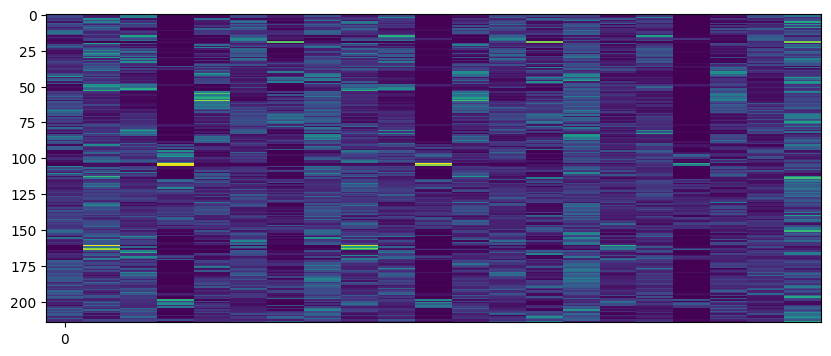

In [275]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

In [8]:
def split_sessions(trial_clusters, n_parts):

    rng = np.random.default_rng() 

    trial_clusters['session_part'] = trial_clusters['response'] * np.nan

    for s, session in enumerate(trial_clusters.session.unique()):
        session_df = trial_clusters.loc[trial_clusters['session']==session]
        n_trials = len(session_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        trial_clusters.loc[trial_clusters['session']==session, 'session_part'] = parts

    # Assign to new column
    trial_clusters['session_part'] = trial_clusters['session_part'].astype(str)
    trial_clusters = trial_clusters.rename(columns={"sample": "old_sample"})
    trial_clusters['sample'] = trial_clusters[['session', 'session_part']].agg(' '.join, axis=1)
    
    split_session_df = trial_clusters.copy()
    
    return split_session_df


def get_fraction_vectors(trial_clusters, target_length):

    all_sequences = pd.DataFrame(columns=['sample', 'mouse_name', 'session', 'trial_type', 'cluster', 'bin'])
    for s, sample in enumerate(trial_clusters['sample'].unique()):

        # Get session data and order trials
        session_data = trial_clusters.loc[trial_clusters['sample']==sample]
        session_data = session_data[['sample', 'mouse_name', 'session', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        # Bin 
        n_trials = len(session_data)
        # Assign bin index: split into 10 parts
        bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
        session_data['bin'] = bin_indices
        
        all_sequences = pd.concat([all_sequences, session_data[['sample', 'mouse_name', 'session', 
                                                                'trial_type', 'cluster', 'bin']]], ignore_index=True)

    fractions = all_sequences.groupby(['sample', 'mouse_name', 'session',
                                    'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
    design_df = fractions.pivot(index=['mouse_name', 'sample', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)

    return design_df
    
    
def prepare_design_mat(design_df):
    decoded_var = 'mouse_name'
    var = 'fact_var'

    mat = pd.DataFrame(design_df)
    mat['fact_var'] = pd.factorize(design_df[decoded_var])[0]
    mat[decoded_var] = design_df[decoded_var]

    use_labels = mat['fact_var'].unique()

    session_mouse_names = mat.loc[mat['fact_var'].isin(use_labels), decoded_var]
    session_names = pd.factorize(design_df['session'])[0]
    named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
    use_mat_pre = mat.loc[mat['fact_var'].isin(use_labels)]
    array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))
    use_mat = pd.DataFrame(array_mat[:, :-1])
    use_mat[var] = use_mat_pre[var]
    
    return use_mat, named_labels, session_mouse_names, session_names 

In [9]:
n_parts = 2
target_length = 3
repeats = 200

## Repeated samplings

In [12]:
samplings_df = pd.DataFrame(columns=['repeat', 'matrix', 'distance_matrix'], index=range(repeats))

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
        
    # Split data anew
    split_session_df = split_sessions(trial_clusters, n_parts)
    split_session_df = split_session_df.loc[split_session_df['session_part']=='0.0']  # Use only one sample per session each time
    design_df = get_fraction_vectors(split_session_df, target_length)
    use_mat, named_labels, session_mouse_names, session_names = prepare_design_mat(design_df)
    # pairwise_matrix = np.zeros((np.shape(use_mat)[0], np.shape(use_mat)[0])) * np.nan
    pairwise_matrix = pairwise_distances(use_mat.drop(columns='fact_var'), metric='cosine')

    # Save results
    samplings_df.loc[r, 'repeat'] = r
    samplings_df.loc[r, 'matrix'] = np.array(use_mat.drop(columns='fact_var'))
    samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix
    

Repeat 1 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 2 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 3 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 4 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 5 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 6 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 7 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 8 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 9 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 10 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 11 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 12 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 13 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 14 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 15 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 16 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 17 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 18 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 19 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 20 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 21 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 22 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 23 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 24 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 25 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 26 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 27 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 28 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 29 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 30 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 31 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 32 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 33 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 34 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 35 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 36 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 37 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 38 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 39 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 40 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 41 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 42 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 43 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 44 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 45 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 46 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 47 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 48 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 49 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 50 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 51 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 52 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 53 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 54 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 55 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 56 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 57 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 58 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 59 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 60 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 61 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 62 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 63 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 64 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 65 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 66 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 67 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 68 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 69 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 70 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 71 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 72 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 73 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 74 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 75 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 76 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 77 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 78 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 79 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 80 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 81 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 82 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 83 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 84 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 85 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 86 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 87 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 88 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 89 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 90 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 91 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 92 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 93 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 94 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 95 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 96 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 97 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 98 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 99 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 100 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 101 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 102 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 103 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 104 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 105 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 106 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 107 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 108 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 109 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 110 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 111 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 112 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 113 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 114 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 115 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 116 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 117 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 118 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 119 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 120 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 121 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 122 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 123 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 124 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 125 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 126 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 127 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 128 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 129 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 130 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 131 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 132 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 133 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 134 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 135 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 136 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 137 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 138 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 139 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 140 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 141 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 142 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 143 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 144 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 145 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 146 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 147 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 148 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 149 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 150 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 151 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 152 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 153 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 154 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 155 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 156 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 157 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 158 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 159 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 160 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 161 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 162 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 163 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 164 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 165 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 166 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 167 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 168 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 169 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 170 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 171 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 172 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 173 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 174 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 175 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 176 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 177 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 178 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 179 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 180 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 181 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 182 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 183 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 184 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 185 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 186 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 187 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 188 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 189 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 190 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 191 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 192 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 193 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 194 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 195 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 196 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 197 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 198 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 199 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


Repeat 200 of 200


/tmp/ipykernel_18687/607950693.py:67: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))


In [15]:
samplings_df

,repeat,matrix,distance_matrix,clusters
0,0,"[[0.13402061855670103, 0.4329896907216495, 0.0...","[[0.0, 0.39731371657421055, 0.4646446617303673...","[3, 2, 2, 3, 1, 3, 3, 1, 3, 2, 3, 1, 1, 1, 1, ..."
1,1,"[[0.13402061855670103, 0.36082474226804123, 0....","[[0.0, 0.3875071447328665, 0.45985348632386114...","[1, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,"[[0.13402061855670103, 0.3402061855670103, 0.0...","[[0.0, 0.41035366682692087, 0.4458929319190197...","[1, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,"[[0.10309278350515463, 0.4020618556701031, 0.0...","[[0.0, 0.38443783010648336, 0.4356935387686130...","[3, 2, 3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 1, 1, 1, ..."
4,4,"[[0.17525773195876287, 0.35051546391752575, 0....","[[3.3306690738754696e-16, 0.3686698641436952, ...","[3, 2, 2, 3, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, ..."
...,...,...,...,...
195,195,"[[0.15463917525773196, 0.31958762886597936, 0....","[[0.0, 0.3994425584367206, 0.4483830596100259,...","[3, 2, 2, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, ..."
196,196,"[[0.12371134020618557, 0.3711340206185567, 0.0...","[[2.220446049250313e-16, 0.3961974972646004, 0...","[3, 2, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, ..."
197,197,"[[0.12371134020618557, 0.38144329896907214, 0....","[[0.0, 0.411406464982103, 0.5001471963285169, ...","[3, 2, 2, 3, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, ..."
198,198,"[[0.14432989690721648, 0.41237113402061853, 0....","[[0.0, 0.42401304336263457, 0.4659736705446851...","[3, 2, 2, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, ..."


## Cluster each repeat and build consensus matrix

/tmp/ipykernel_18687/2396980262.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/tmp/ipykernel_18687/2396980262.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: 

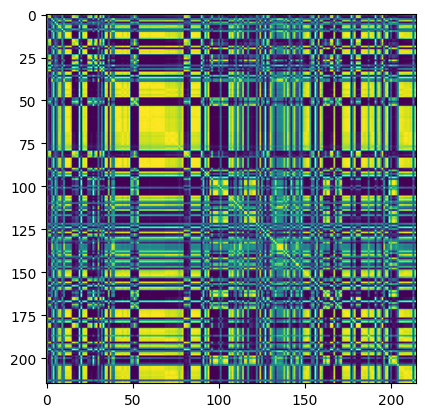

In [14]:
k = 3
samplings_df['clusters'] = samplings_df['repeat'] * np.nan
n_samples, _ = pairwise_matrix.shape
consensus_matrix = np.zeros((n_samples, n_samples))

for r in range(repeats):
    pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
    linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
    # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
    # plt.show()
    
    clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    samplings_df['clusters'][r] = clusters 

    for i in range(n_samples):
        for j in range(i, n_samples):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1
                if i != j:
                    consensus_matrix[j, i] += 1  # symmetry
                            
# Normalize to [0, 1]
consensus_matrix /= repeats
plt.imshow(consensus_matrix)

Text(0.5, 1.0, 'Pairwise cosine similarity between sessions')

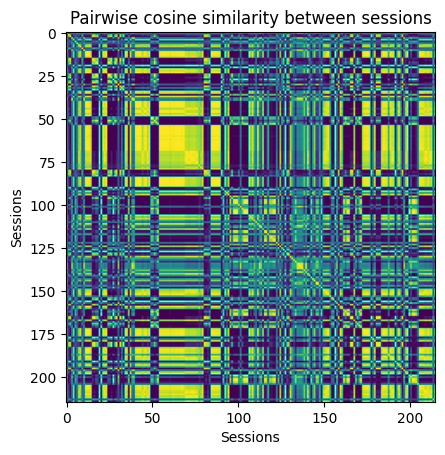

In [318]:
plt.imshow(consensus_matrix)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Pairwise cosine similarity between sessions')


(0.0, 200.0)

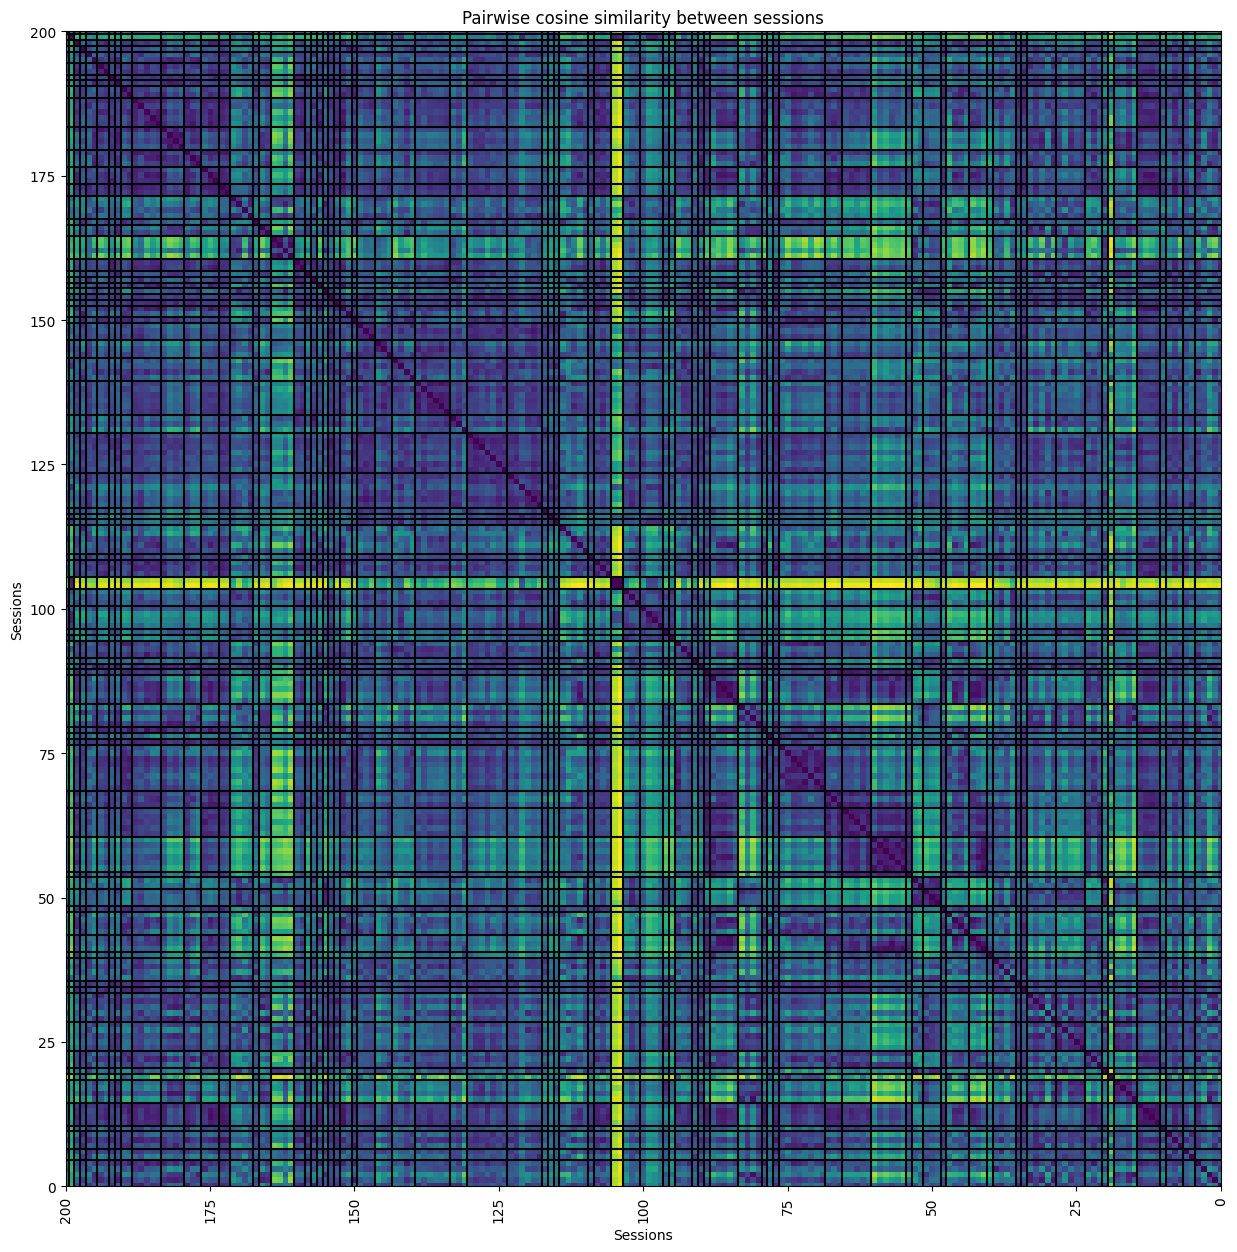

In [341]:
fig, ax = plt.subplots(figsize=[20, 15])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0))
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Pairwise cosine similarity between sessions')

mouse_numbers = pd.factorize(design_df['mouse_name'])[0]
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='k')
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='k')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)


plt.xlim([np.shape(samplings_df['distance_matrix'])[0], 0])
plt.ylim([0, np.shape(samplings_df['distance_matrix'])[0]])

In [52]:
from scipy.stats import entropy

#def calculate_entropy(all_cluster_repeats):
mice = design_df['mouse_name'].unique()
mouse_numbers = pd.factorize(design_df['mouse_name'])[0]
cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'])

for m, mouse in enumerate(design_df['mouse_name'].unique()):
    # cluster_entropy['mouse_name'][m] = mouse

    mouse_repeats = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'], index=range(repeats))
    
    agree = []
    shuffle_agree = []
    for r, rep in enumerate(range(repeats)):

        repeat_data = list(samplings_df.loc[samplings_df['repeat']==r, 'clusters'])[0]
        mouse_session_clusters = repeat_data[np.where(mouse_numbers==m)]
        if len(mouse_session_clusters) > 0:
        
            # repeat_data = mouse_session_parts.loc[mouse_session_parts['repeat']==r, 'y_kmeans']
            # Count cluster label occurrences for sample i
            labels, counts = np.unique(np.array(mouse_session_clusters), return_counts=True)
            prob = counts / counts.sum()
            ent = entropy(prob)  # Shannon entropy
            # same = 1 if np.array(repeat_data)[0] == np.array(repeat_data)[1] else 0
            # agree.append(same)
            agree.append(ent)

            # Test for random cluster assignment
            shuffle = np.random.randint(np.min(repeat_data), np.max(repeat_data), len(mouse_session_clusters))
            # same_shuffle = 1 if shuffle[0]==shuffle[1] else 0
            # shuffle_agree.append(same_shuffle)
            _, shuffle_counts = np.unique(shuffle, return_counts=True)
            shuff_prob = shuffle_counts / shuffle_counts.sum()
            shuff_ent = entropy(shuff_prob)  # Shannon entropy
            shuffle_agree.append(shuff_ent)
            
        mouse_repeats['mouse_name'][r] = mouse
        mouse_repeats['True'][r] = np.mean(agree)
        mouse_repeats['Shuffled'][r] = np.mean(shuffle_agree)
        mouse_repeats['session_len'][r] = len(mouse_session_clusters)
    
    cluster_entropy = pd.concat([cluster_entropy, mouse_repeats])
    
    # cluster_entropy['True'][m] = np.mean(agree)
    # cluster_entropy['Shuffled'][m] = np.mean(shuffle_agree)
    # cluster_entropy['session_len'][m] = len(mouse_session_clusters)

melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name', 'session_len'], value_vars=['True', 'Shuffled'])

/tmp/ipykernel_18687/4021477868.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_repeats['mouse_name'][r] = mouse
/tmp/ipykernel_18687/4021477868.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Yo

In [53]:
melted_df.groupby(['mouse_name', 'variable', 'session_len'])['value'].mean().reset_index()

,mouse_name,variable,session_len,value
0,CSHL045,Shuffled,5,0.56404
1,CSHL045,True,5,0.873996
2,CSHL047,Shuffled,2,0.316699
3,CSHL047,True,2,0.461788
4,CSHL049,Shuffled,3,0.424651
...,...,...,...,...
157,ibl_witten_26,True,4,0.249919
158,ibl_witten_27,Shuffled,3,0.46882
159,ibl_witten_27,True,3,0.380431
160,ibl_witten_29,Shuffled,8,0.604177


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 79.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 89.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='variable', ylabel='value'>

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 88.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 93.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


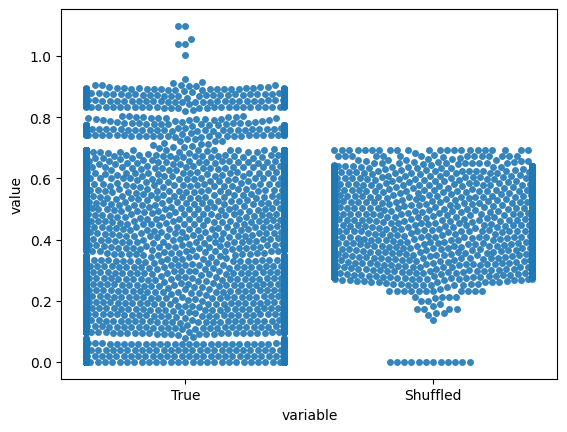

In [58]:
# sns.violinplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1], alpha=0.9) # , hue='session_len'
sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1], alpha=0.9) # , hue='session_len'

<Axes: xlabel='variable', ylabel='value'>

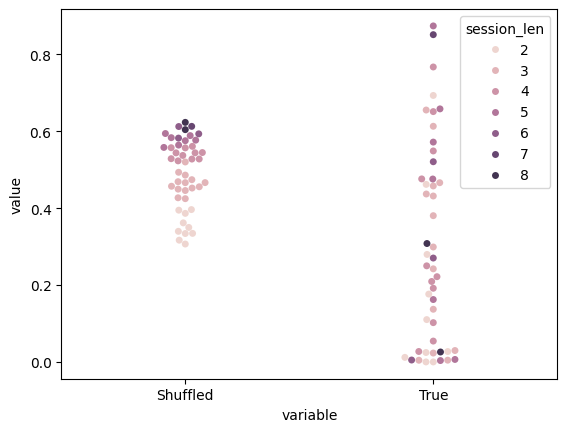

In [54]:
mice_mean_entropy = melted_df.groupby(['mouse_name', 'variable', 'session_len'])['value'].mean().reset_index()
sns.swarmplot(x='variable', y='value', data=mice_mean_entropy.loc[mice_mean_entropy['session_len']>1], alpha=0.9, hue='session_len')
# sns.boxplot(x='variable', y='value', data=mice_meac_entropy.loc[mice_meac_entropy['session_len']>1])
# sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1])

## Pairwise distance distributions

In [310]:
mice = design_df['mouse_name'].unique()

samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix
mouse_distance_df = pd.DataFrame(columns=['mouse_name', 'distance', 'random'], index =range(len(mice)))

for m, mouse in enumerate(mice):
    
    mouse_sessions = np.where(np.array(design_df['mouse_name'])==mouse)[0]
    random_sessions = np.random.choice(215, len(mouse_sessions))
    mouse_distances = np.zeros(repeats)*np.nan
    random_distances = np.zeros(repeats)*np.nan

    if len(mouse_sessions) > 1:
        for r in range(repeats):
            repeat_matrix = samplings_df.loc[r, 'distance_matrix']
            mouse_distances[r] = np.nanmean(repeat_matrix[np.ix_(mouse_sessions, mouse_sessions)])
            random_distances[r] = np.nanmean(repeat_matrix[np.ix_(random_sessions, random_sessions)])
        mouse_distance_df['distance'][m] = np.nanmean(mouse_distances)
        mouse_distance_df['random'][m] = np.nanmean(random_distances)

    else:
        mouse_distance_df['distance'][m] = np.nan
        mouse_distance_df['random'][m] = np.nan
    mouse_distance_df['mouse_name'][m] = mouse


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53570/1528738890.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_distance_df['distance'][m] = np.nanmean(mouse_distances)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/

Text(0.5, 0, 'Cosine distance')

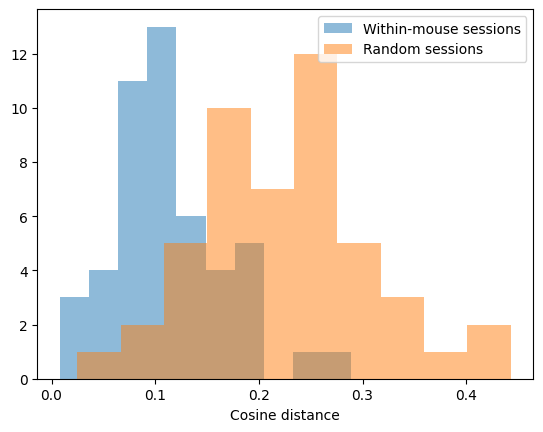

In [316]:
plt.hist(mouse_distance_df['distance'], alpha=0.5, label='Within-mouse sessions')
plt.hist(mouse_distance_df['random'], alpha=0.5, label='Random sessions')
plt.legend()
plt.xlabel('Cosine distance')

In [262]:
final_clustering = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage="average")
final_clusters = final_clustering.fit_predict(1 - consensus_matrix)  # Convert to similarity
design_df['session_cluster'] = final_clusters 

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:566: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


(array([ 70.,   0.,   0.,   0.,   0., 106.,   0.,   0.,   0.,  39.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

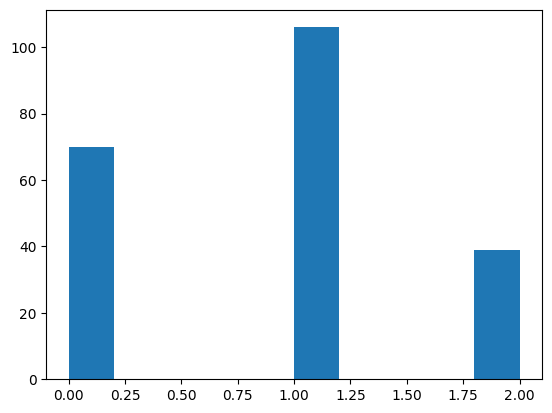

In [263]:
plt.hist(final_clusters)

array([[1.   , 0.735, 0.66 , ..., 0.84 , 0.825, 0.55 ],
       [0.735, 1.   , 0.615, ..., 0.895, 0.91 , 0.565],
       [0.66 , 0.615, 1.   , ..., 0.645, 0.66 , 0.53 ],
       ...,
       [0.84 , 0.895, 0.645, ..., 1.   , 0.975, 0.565],
       [0.825, 0.91 , 0.66 , ..., 0.975, 1.   , 0.57 ],
       [0.55 , 0.565, 0.53 , ..., 0.565, 0.57 , 1.   ]])

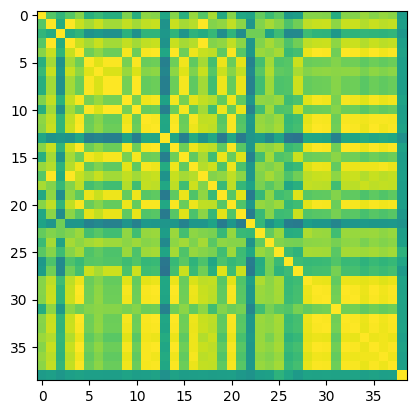

In [264]:
cluster_1 = np.where(final_clusters==2)[0]
plt.imshow(consensus_matrix[np.ix_(cluster_1, cluster_1)], vmin=0, vmax=1)
consensus_matrix[np.ix_(cluster_1, cluster_1)]

## Save

In [ ]:
file_to_save = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']].copy()
filename = "cluster_per_session_dendogram"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.8_clustering_session_sequences_dendogram.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

In [265]:
new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']]
filename = "cluster_per_session_dendogram"
new_df.to_parquet(filename)  

## Prepare design matrix

In [33]:
ori_X = final_matrix.copy()

print(np.shape(ori_X))

(215, 21)


## Pairwise cosyne distances

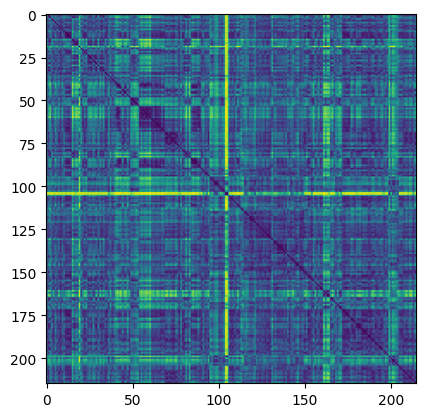

In [34]:
cos_dist = pairwise_distances(ori_X, metric='cosine')
plt.imshow(cos_dist)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53570/101162269.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method, metric='cosine')


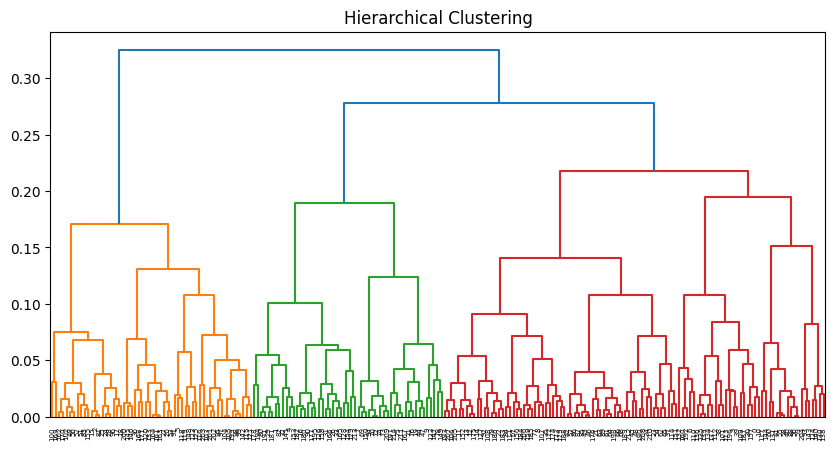

In [255]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine


def plot_dendrogram(distance_matrix, method, title="Hierarchical Clustering"):
    """
    Performs hierarchical clustering and plots a dendrogram.
    """
    linkage_matrix = sch.linkage(distance_matrix, method, metric='cosine')
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, leaf_rotation=90)
    plt.title(title)
    plt.show()
    return linkage_matrix
    
linkage_matrix = plot_dendrogram(cos_dist, 'complete', title="Hierarchical Clustering")

In [68]:
from scipy.cluster.hierarchy import fcluster
k = 3
clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
design_df['session_cluster'] = clusters 

(array([ 56.,   0.,   0.,   0.,   0.,  53.,   0.,   0.,   0., 106.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

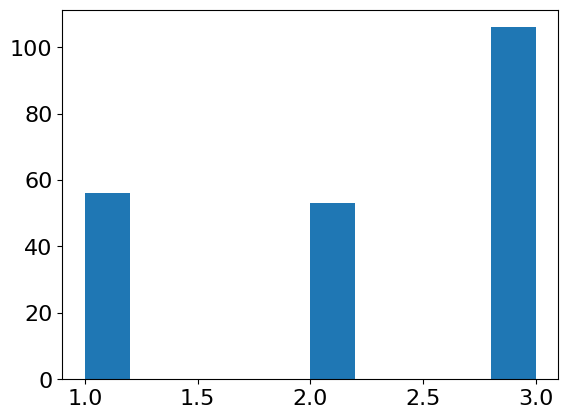

In [214]:
plt.hist(clusters)

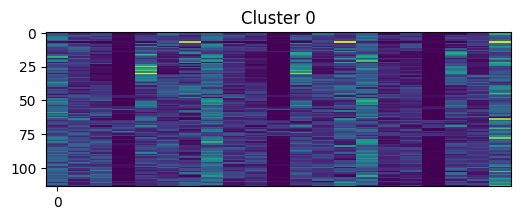

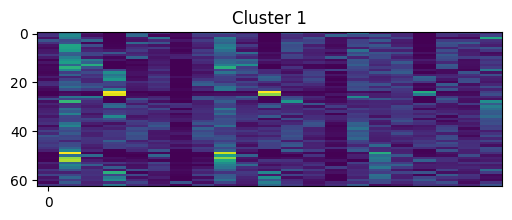

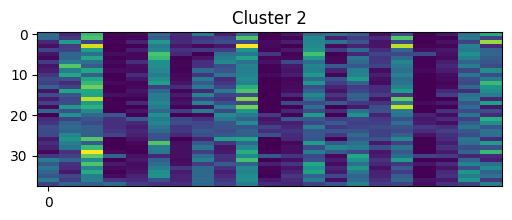

In [237]:
for c, cluster in enumerate(np.unique(final_clusters)):
    indices = np.where(final_clusters==cluster)[0]
    data = np.array(final_matrix)[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53570/918539812.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  new_df = final_matrix.stack(0).unstack()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53570/918539812.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53570/918539812.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What

Text(0.5, 0, 'Session fraction')

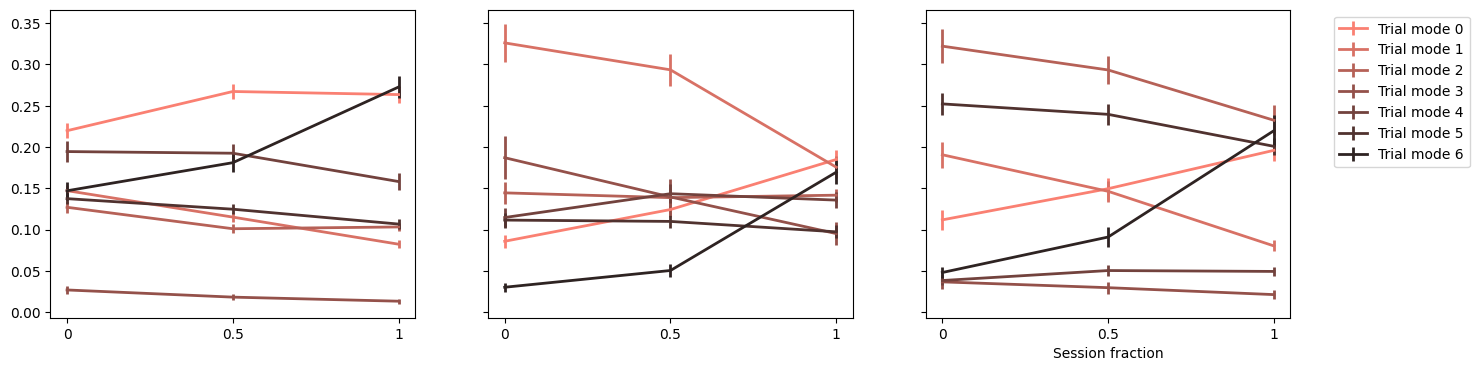

In [246]:
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())

fig, axs = plt.subplots(1, len(np.unique(final_clusters)), sharex=True, sharey=True, figsize=(16, 4))

for c, cluster in enumerate(np.unique(final_clusters)):
    new_df = final_matrix.stack(0).unstack()
    use_data = new_df.iloc[np.where(final_clusters==cluster)]
    sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    for t, trial in enumerate([0, 1, 2, 3, 4, 5, 6]):
        axs[c].errorbar(np.arange(0, target_length), 
                        np.nanmean(use_data[t], axis=0),
                        np.nanstd(use_data[t], axis=0)/np.sqrt(np.shape(use_data[t])[0]), linewidth=2, 
                        color=my_cmap(t), label=str('Trial mode '+str(t)))
        
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
axs[2].set_xticks([0, 1, 2], [0, 0.5, 1])
plt.xlabel('Session fraction')
# plt.ylabel('Fraction use')



In [217]:
new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']]

In [222]:
file_to_save = new_df.copy()
filename = "cluster_per_session_dendogram"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.8_clustering_session_sequences_dendogram.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Correlates of session clusters

In [140]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

/tmp/ipykernel_8718/3499453394.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [219]:
df = new_df.merge(learning_times, on='mouse_name')

In [220]:
data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

a = df[['mouse_name', 'training_time']].merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_8718/1478564848.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))


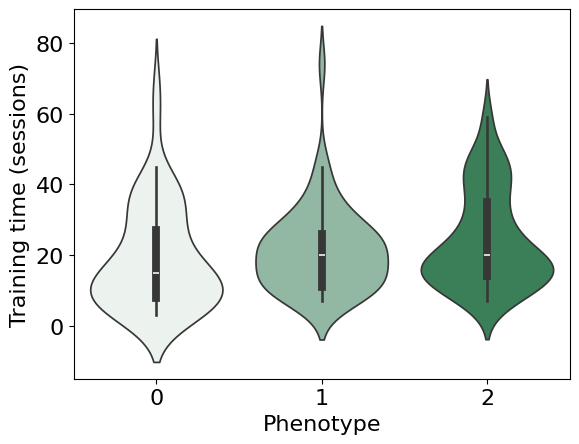

P-value for KW: 0.020
          1         2        3
1  1.000000  0.313108  0.01586
2  0.313108  1.000000  1.00000
3  0.015860  1.000000  1.00000


In [223]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

# print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['session_cluster'], alpha=0.05)
# print(tukey)

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 80])
plt.xlabel('Phenotype')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.show()

group_1 = df.loc[df['session_cluster']==1, var]
group_2 = df.loc[df['session_cluster']==2, var]
group_3 = df.loc[df['session_cluster']==3, var]
# group_4 = df.loc[df['session_cluster']==4, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)